# **Bank Marketing Campaign Optimization**

## **1. Introduction**

### **1.1 Context**

The dataset comes from a marketing campaign of a banking institution. It contains customer demographic information (such as age, job, marital status, education), financial data (account balance, loans, defaults, housing), and details about marketing contacts (communication channel, month, day, campaign duration, previous attempts, days since last contact from a previous campaign, and outcomes). The main goal of the campaign was to encourage customers to subscribe to a term deposit. 

### **1.2 Objective**

The objective  is to deliver actionable recommendations that help optimize future marketing strategies, improve targeting, and reduce risk exposure for the bank.

### **1.3 Business Questions**

1. **Customer Profiling**  
   - What are the demographic and financial characteristics (age, job, marital status, education, account balance, loans, etc.) of customers who subscribed to a term deposit compared to those who did not?  
  
2. **Channel & Campaign Effectiveness**  
   - Which communication channel (cellular, telephone, etc.) is most effective in achieving customer subscriptions?
   - Does having been contacted in a previous campaign (vs. never being contacted before) affect the likelihood of subscription in the current campaign?
   - What is the most effective timing for contact (month, day of the week, or days since the last contact from a previous campaign) in maximizing subscription likelihood?
   - How does the duration of a call influence the probability of securing a subscription?
   - Does the frequency of contact (number of attempts within the current and previous campaigns) impact the success rate?
   - How does the outcome of previous campaigns affect the probability of subscription in the current campaign?

## **2. Import Libraries**

In [9]:
# Numerical computing and array manipulation
import numpy as np  

# Data manipulation and analysis
import pandas as pd  

# Data visualization
import matplotlib.pyplot as plt  

# Statistical tests (chi-square test of independence)
from scipy.stats import chi2_contingency  

## **3. Data Collection and Initial Exploration**

In this step, we load the dataset and perform a first look at its structure.  
The goal is to understand the **shape of the data, variable types, missing or unknown values, and potential duplicates**.  
This initial exploration helps to identify possible data quality issues and provides context for the next steps in cleaning and analysis.  
We also generate basic descriptive statistics for numerical features and review unique values for categorical variables, which is essential for spotting irregularities and preparing for deeper exploration.  

##### **Data Dictionary**
- **age** *(int)*: Client age (years).  
- **job** *(category)*: Type of job (e.g., admin., technician, services, management, student, retired).  
- **marital** *(category)*: Marital status (single, married, divorced).  
- **education** *(category)*: Education level (primary, secondary, tertiary, unknown).  
- **default** *(category)*: Has credit in default? (yes/no/unknown).  
- **balance** *(int)*: Average yearly balance in euros.  
- **housing** *(category)*: Has a housing loan? (yes/no/unknown).  
- **loan** *(category)*: Has a personal loan? (yes/no/unknown).  
- **contact** *(category)*: Contact communication type (cellular/telephone/unknown).  
- **day** *(int)*: Last contact day of the month (1–31).  
- **month** *(category)*: Last contact month (jan–dec).  
- **duration** *(int)*: Last contact duration, in seconds.  
- **campaign** *(int)*: Number of contacts performed during this campaign for this client.  
- **pdays** *(int)*: Days passed since the client was last contacted from a previous campaign (−1 means never).  
- **previous** *(int)*: Number of contacts performed before this campaign.  
- **poutcome** *(category)*: Outcome of the previous marketing campaign (success/failure/other/unknown).  
- **y** *(binary target)*: Has the client subscribed to a term deposit? (1=yes, 0=no).

In [140]:
# -----------------------------
# Step 1: Load dataset from CSV into a pandas DataFrame
# -----------------------------
df = pd.read_csv("train.csv")

# -----------------------------
# Step 2: Preview dataset shape and first rows 
# (excluding the 'id' column)
# -----------------------------
print("=== Data preview ===", df.drop(columns="id").shape)
print(df.drop(columns="id").head(5))

# -----------------------------
# Step 3: Check data types, missing values, and 'unknown' placeholders
# (for categorical variables where 'unknown' is used instead of NaN)
# -----------------------------
print("\n=== Data types and basic info ===")
info_df = pd.DataFrame({
    "dtype": df.drop(columns="id").dtypes,
    "null": df.drop(columns="id").isnull().sum(),
    "unknown": df.drop(columns="id").apply(
        lambda col: (col.astype(str).str.lower() == "unknown").sum()
        if col.dtype == "object" else 0
    )
})
print(info_df.sort_values(by="unknown", ascending=False))

# -----------------------------
# Step 4: Basic descriptive statistics for numerical features
# -----------------------------
print("\n=== Descriptive statistics (Numerical) ===")
print(df.drop(columns=["id", "y"]).describe())

# -----------------------------
# Step 5: Explore categorical features by showing
# the number of unique values and a sample of categories
# -----------------------------
print("\n=== Unique values per column (Categorical) ===")
cat_cols = df.select_dtypes(include="object")
unique_summary = pd.DataFrame({
    "Unique Count": cat_cols.nunique(),
    "Sample Values": cat_cols.apply(lambda x: x.unique()[:10])
})
print(unique_summary)

# -----------------------------
# Step 6: Check for duplicate rows in the dataset
# -----------------------------
duplicates = df.duplicated().sum()
print("\n=== Duplicate Rows ===")
print(f"Number of duplicate rows: {duplicates}")

=== Data preview === (750000, 17)
   age          job  marital  education default  balance housing loan  \
0   42   technician  married  secondary      no        7      no   no   
1   38  blue-collar  married  secondary      no      514      no   no   
2   36  blue-collar  married  secondary      no      602     yes   no   
3   27      student   single  secondary      no       34     yes   no   
4   26   technician  married  secondary      no      889     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  y  
0  cellular   25   aug       117         3     -1         0  unknown  0  
1   unknown   18   jun       185         1     -1         0  unknown  0  
2   unknown   14   may       111         2     -1         0  unknown  0  
3   unknown   28   may        10         2     -1         0  unknown  0  
4  cellular    3   feb       902         1     -1         0  unknown  1  

=== Data types and basic info ===
            dtype  null  unknown
poutcome   obje

## **4. Data Cleaning**
In this section, we standardize and sanitize the dataset.  
We normalize categorical values (consistent casing, whitespace removal, and proper handling of “unknown”/nulls), standardize booleans, and validate numeric/date-like fields (e.g., `day`, `month`, `duration`, `campaign`, `pdays`, `previous`, `age`, `balance`).  
We also optimize categorical dtypes, remove duplicates, and create helpful **derived buckets** (e.g., `day_group`, `age_group`) to support downstream EDA and business questions.

In [146]:
# Work on a safe copy to preserve the original dataset
df_clean = df.copy()

# -----------------------------
# Step 1: Normalize categorical columns
# - Unify casing and strip whitespace for consistent categories
# - Convert literal strings like "nan"/"none"/"null" into real NaNs
# - Keep "contact" as 'unknown' if present, but for selected fields, track and nullify "unknown"
# -----------------------------
cat_cols = df_clean.select_dtypes(include="object").columns.tolist()

# Standardize strings: strip spaces and lowercase
for c in cat_cols:
    df_clean[c] = df_clean[c].astype(str).str.strip().str.lower()

# Replace string placeholders with proper NaN
for c in cat_cols:
    df_clean.loc[df_clean[c].isin(["nan", "none", "null"]), c] = pd.NA

# Treat "unknown" as missing for selected columns, but keep a flag for modeling/EDA
unknown_as_na = ["job", "education", "poutcome"]
for c in unknown_as_na:
    if c in df_clean.columns:
        df_clean[f"{c}_unknown_flag"] = (df_clean[c] == "unknown").astype("int8")
        df_clean.loc[df_clean[c] == "unknown", c] = pd.NA

# -----------------------------
# Step 2: Standardize booleans (yes/no -> 1/0)
# - Convert common yes/no fields to numeric Int8
# - Convert the target 'y' as well, if present
# -----------------------------
bool_map = {"yes": 1, "no": 0}
for c in ["default", "housing", "loan"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].map(bool_map).astype("Int8")
if "y" in df_clean.columns:
    df_clean["y"] = df_clean["y"].replace(bool_map).astype("Int8")

# -----------------------------
# Step 3: Validate and coerce date-like and numeric fields
# - 'day': valid range [1, 31]
# - 'month': map to numeric order (1-12)
# - 'duration': non-negative
# - 'campaign': should be >= 1
# - 'pdays': -1 means "not previously contacted" -> set to NaN and create a binary flag
# - 'previous': should be >= 0
# - Coerce 'age' and 'balance' to proper numeric types
# -----------------------------
# Day
if "day" in df_clean.columns:
    df_clean["day"] = pd.to_numeric(df_clean["day"], errors="coerce").astype("Int16")
    df_clean.loc[(df_clean["day"] < 1) | (df_clean["day"] > 31), "day"] = pd.NA

# Month (string -> numeric)
month_map = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
             "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}
if "month" in df_clean.columns:
    df_clean["month_num"] = df_clean["month"].map(month_map).astype("Int8")

# Duration must be non-negative
if "duration" in df_clean.columns:
    df_clean["duration"] = pd.to_numeric(df_clean["duration"], errors="coerce").astype("Float32")
    df_clean.loc[df_clean["duration"] < 0, "duration"] = np.nan

# Campaign >= 1
if "campaign" in df_clean.columns:
    df_clean["campaign"] = pd.to_numeric(df_clean["campaign"], errors="coerce").astype("Float32")
    df_clean.loc[df_clean["campaign"] < 1, "campaign"] = np.nan

# pdays: -1 means "not previously contacted"
if "pdays" in df_clean.columns:
    df_clean["pdays"] = pd.to_numeric(df_clean["pdays"], errors="coerce").astype("Float32")
    df_clean["prev_contact_flag"] = (df_clean["pdays"] >= 0).astype("Int8")
    df_clean.loc[df_clean["pdays"] < 0, "pdays"] = np.nan

# previous: number of contacts before this campaign should be >= 0
if "previous" in df_clean.columns:
    df_clean["previous"] = pd.to_numeric(df_clean["previous"], errors="coerce").astype("Float32")
    df_clean.loc[df_clean["previous"] < 0, "previous"] = np.nan

# age
if "age" in df_clean.columns:
    df_clean["age"] = pd.to_numeric(df_clean["age"], errors="coerce").astype("Int16")

# balance
if "balance" in df_clean.columns:
    df_clean["balance"] = pd.to_numeric(df_clean["balance"], errors="coerce").astype("Float64")

# -----------------------------
# Step 4: Categorical optimization
# - Convert frequent string columns to categorical dtype to save memory
# -----------------------------
to_category = ["job", "marital", "education", "contact", "poutcome", "month"]
for c in to_category:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].astype("category")

# -----------------------------
# Step 5: Remove duplicates
# - Drop exact duplicate rows
# -----------------------------
dup_count = df_clean.duplicated().sum()
if dup_count > 0:
    df_clean = df_clean.drop_duplicates(keep="first")

# -----------------------------
# Step 6: Derived buckets / categorical groupings
# - Create interpretable bins for 'day' and 'age' to aid EDA
# -----------------------------
# Day groups: start / mid / end of month
if "day" in df_clean.columns:
    day_bins = [0, 10, 20, 31]
    day_labels = ["start_month", "mid_month", "end_month"]
    df_clean["day_group"] = pd.cut(
        df_clean["day"],
        bins=day_bins,
        labels=day_labels,
        right=True,
        include_lowest=True
    )
    df_clean["day_group"] = df_clean["day_group"].astype(
        pd.CategoricalDtype(categories=day_labels, ordered=True)
    )

# Age groups: young / adult / senior
if "age" in df_clean.columns:
    age_bins = [0, 35, 65, 130]
    age_labels = ["young", "adult", "senior"]
    df_clean["age_group"] = pd.cut(
        df_clean["age"],
        bins=age_bins,
        labels=age_labels,
        right=False,
        include_lowest=True
    )
    df_clean["age_group"] = df_clean["age_group"].astype(
        pd.CategoricalDtype(categories=age_labels, ordered=True)
    )

# -----------------------------
# Step 7: Quick sanity check of results
# - Show shape and head (excluding id) and an info table of dtypes and nulls
# -----------------------------
print("=== Data preview ===", df_clean.shape)
print(df_clean.drop(columns="id").head(5))

print("\n=== Data types and basic info ===")
info_df = pd.DataFrame({
    "dtype": df_clean.drop(columns="id").dtypes,
    "null": df_clean.drop(columns="id").isnull().sum(),
    # Count remaining 'unknown' categories (if any) in categorical columns
    "unknown": df_clean.drop(columns="id").apply(
        lambda col: (col.astype(str).str.lower() == "unknown").sum()
        if col.dtype.name == "category" else 0
    )
})
print(info_df.sort_values(by="null", ascending=False))

=== Data preview === (750000, 25)
   age          job  marital  education  default  balance  housing  loan  \
0   42   technician  married  secondary        0      7.0        0     0   
1   38  blue-collar  married  secondary        0    514.0        0     0   
2   36  blue-collar  married  secondary        0    602.0        1     0   
3   27      student   single  secondary        0     34.0        1     0   
4   26   technician  married  secondary        0    889.0        1     0   

    contact  day  ... previous  poutcome  y  job_unknown_flag  \
0  cellular   25  ...      0.0       NaN  0                 0   
1   unknown   18  ...      0.0       NaN  0                 0   
2   unknown   14  ...      0.0       NaN  0                 0   
3   unknown   28  ...      0.0       NaN  0                 0   
4  cellular    3  ...      0.0       NaN  1                 0   

   education_unknown_flag poutcome_unknown_flag  month_num  prev_contact_flag  \
0                       0            

## 5. **Exploratory Data Analysis**

### **5.1 Target Distribution**

We begin the exploratory analysis by examining the distribution of the target variable `y`, which indicates whether a customer subscribed to a term deposit (1) or not (0).  
We calculate the positive class rate and visualize the distribution with a simple bar chart to get a clear picture of the baseline success rate.

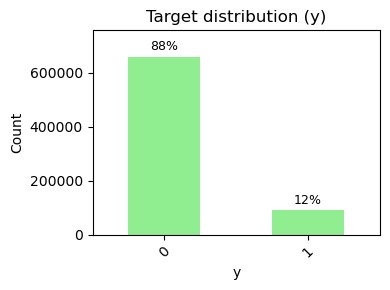

In [368]:
# -----------------------------
# Step 1: Identify numeric and categorical columns
# - Exclude 'id', 'day', and the target column from numeric features
# - For categoricals, include object columns and engineered flags/buckets
# -----------------------------
target_col = 'y' if 'y' in df.columns else None
num_cols = [c for c in df.columns
            if pd.api.types.is_numeric_dtype(df[c])
            and c not in [target_col, 'id', 'day']]
cat_cols = [c for c in df.columns if pd.api.types.is_object_dtype(df[c])] \
           + ['day_group', 'age_group', 'prev_contact_flag']

if target_col is None:
    raise ValueError("Target column 'y' not found.")

# -----------------------------
# Step 2: Plot target distribution
# - Simple bar plot of y=0 vs y=1 proportions
# - Annotated with percentage labels
# -----------------------------
fig, ax = plt.subplots(figsize=(4, 3))

# Absolute counts
counts = df_clean[target_col].value_counts().sort_index()
total = counts.sum()

# Plot bars
counts.plot(kind='bar', color="lightgreen", ax=ax)
ax.set_title('Target distribution (y)')
ax.set_xlabel('y')
ax.set_ylabel('Count')
ax.tick_params(axis="x", rotation=45)

# Set y-axis limit slightly above the maximum count
max_count = counts.max()
ax.set_ylim(0, max_count * 1.15)

# Add percentage labels above bars
for p, val in zip(ax.patches, counts):
    percent = ((val / total) * 100).round().astype(int)
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height() + max_count * 0.02,  # small offset
            f"{percent}%",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

The target distribution is highly imbalanced: only **12% of customers subscribed (y=1)**, while **88% did not (y=0)**.  
This indicates that the dataset is dominated by negative cases. Such imbalance may bias predictive models toward the majority class and reduce sensitivity in identifying potential subscribers.

### **5.2 Numerical Features Distribution**

#### **5.2.1 Histograms & Boxplots**
To understand the behavior of each numerical variable, we visualize **histograms** (shape, skewness, multi-modality) and **boxplots** (spread and outliers).

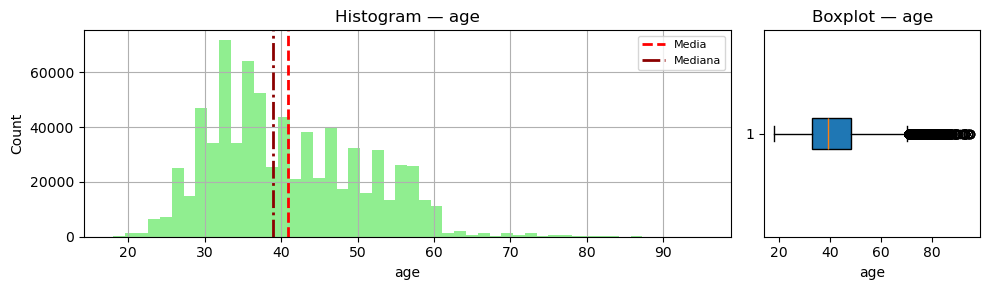

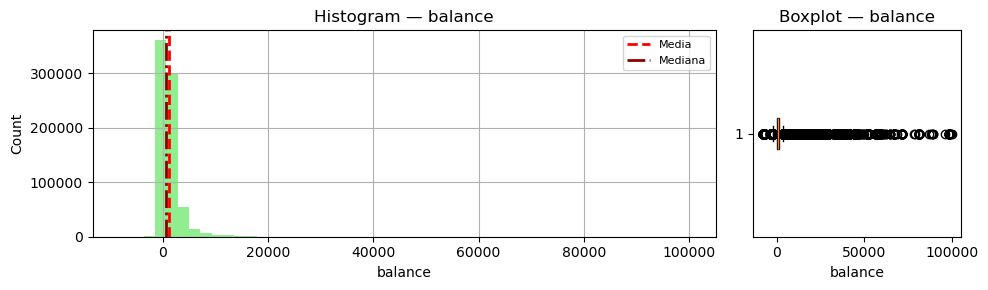

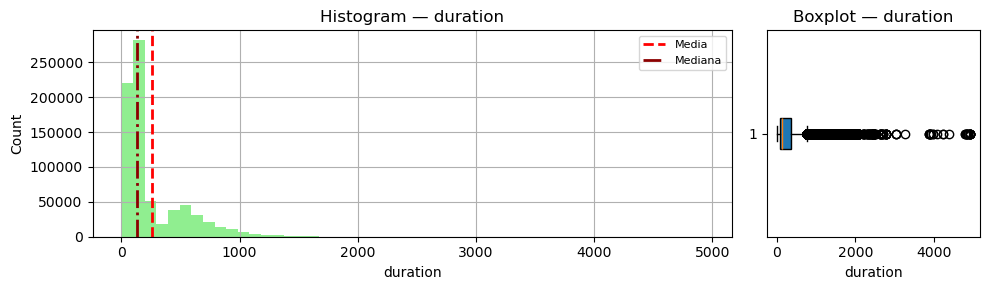

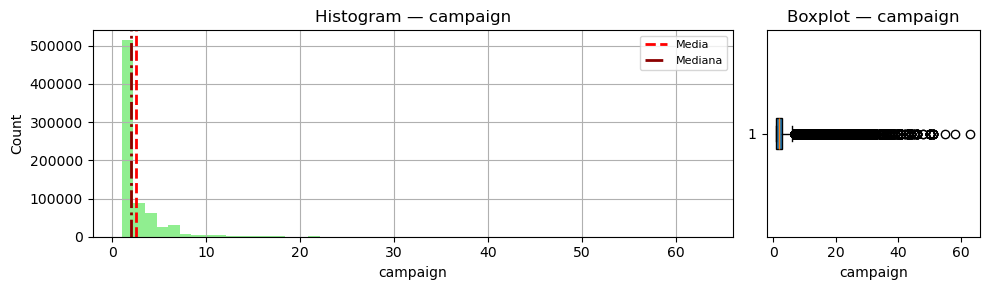

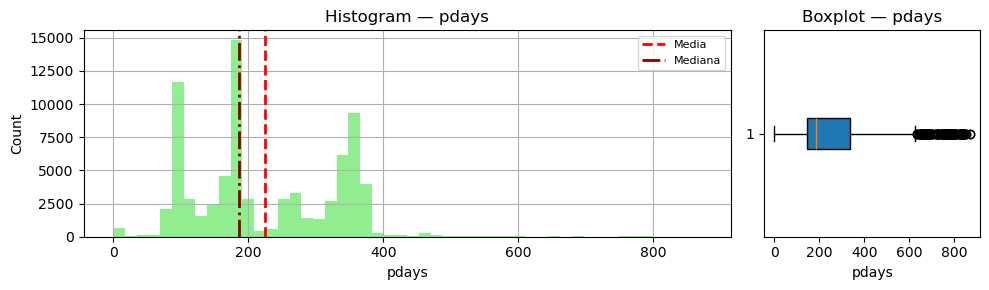

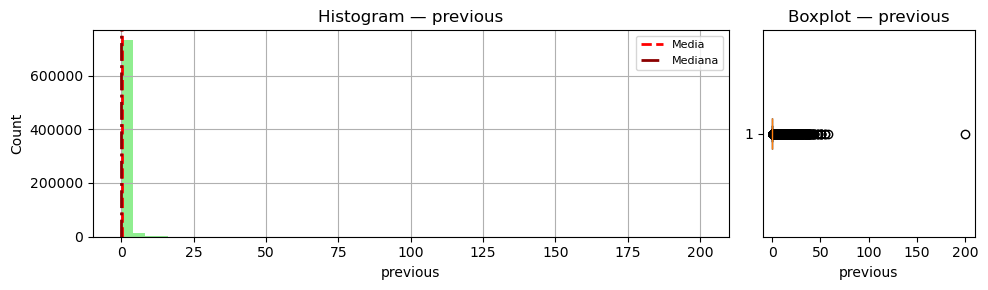

In [345]:
# -----------------------------
# Step 3: Plot histogram & boxplot for each numeric feature
# - Histogram: reveals distribution shape, skewness, and potential multimodality
# - Boxplot: highlights spread and possible outliers
# - Skips columns with insufficient non-null values
# -----------------------------
for c in num_cols:
    series = df_clean[c].dropna()

    # Skip plotting if not enough data points
    if series.size < 2:
        print(f"Skipping {c}: not enough non-null values to plot.")
        continue

    fig, axes = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [3, 1]})

    # Histogram
    series.hist(bins=50, color="lightgreen", ax=axes[0])
    axes[0].set_title(f'Histogram — {c}')
    axes[0].set_xlabel(c)
    axes[0].set_ylabel('Count')

    # Boxplot
    axes[1].boxplot(series, vert=False, patch_artist=True)
    axes[1].set_title(f'Boxplot — {c}')
    axes[1].set_xlabel(c)

    # Lightweight annotations to aid interpretation
    axes[0].axvline(series.mean(), color='red', linestyle='--', linewidth=2, label='Media')
    axes[0].axvline(series.median(), color='darkred', linestyle='-.', linewidth=2, label='Mediana')
    axes[0].legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

#### **5.2.2 Summary statistics**
To complement the visual inspection, we compute descriptive statistics for each numerical feature.  
This includes measures of **central tendency** (mean, median), **dispersion** (standard deviation, range, interquartile range), and **extremes** (min, max).  
These metrics provide a overview of the data distribution and help identify skewness, potential outliers, and variables requiring scaling or transformation.

In [168]:
# -----------------------------
# Step 4: Summary statistics for numeric features
# - Mean & Median: central tendency
# - Std: spread around the mean
# - Min & Max: extremes
# - Range: difference between max and min
# - IQR: interquartile range (Q3 - Q1)
# -----------------------------
summary_stats = pd.DataFrame(index=num_cols)

summary_stats["Mean"] = df_clean[num_cols].mean()
summary_stats["Median"] = df_clean[num_cols].median()
summary_stats["Std"] = df_clean[num_cols].std()
summary_stats["Min"] = df_clean[num_cols].min()
summary_stats["Max"] = df_clean[num_cols].max()
summary_stats["Range"] = summary_stats["Max"] - summary_stats["Min"]
summary_stats["IQR"] = (
    df_clean[num_cols].quantile(0.75) - df_clean[num_cols].quantile(0.25)
)

# Round for readability
print(summary_stats.round(2))

             Mean  Median     Std     Min      Max     Range     IQR
age         40.93    39.0    10.1    18.0     95.0      77.0    15.0
balance   1204.07   634.0  2836.1 -8019.0  99717.0  107736.0  1390.0
duration   256.23   133.0  272.56     1.0   4918.0    4917.0   270.0
campaign     2.58     2.0    2.72     1.0     63.0      62.0     2.0
pdays      225.38   187.0  108.89     0.0    871.0     871.0   194.0
previous      0.3     0.0    1.34     0.0    200.0     200.0     0.0


- **Age**: Customers are on average around 41 years old with a relatively narrow interquartile range (IQR = 15), most are concentrated in the adult segment.  
- **Balance**: The average balance is about €1,200, but the large standard deviation and extreme min/max values indicate strong skewness and the presence of outliers. Most customers have modest balances, while a few hold very high amounts.  
- **Duration**: Call duration is highly skewed: while the mean is 256s (≈4 min), the median is only 133s (≈2 min), showing that most calls are short, with a few very long ones.  
- **Campaign**: The median customer is contacted 2 times, but some cases go up to 63 attempts, suggesting diminishing returns and possible over-contacting.  
- **Pdays**: On average, customers were last contacted about 25 days ago, though the wide range (0–871) shows large variation in recency of contact.  
- **Previous**: Most customers had no previous contacts (median = 0), but a few had an unusually high number (up to 200), which may distort averages.  

Overall, these statistics highlight that several variables (balance, duration, campaign, previous) are highly skewed with extreme outliers.

### **5.3 Categorical feautures distribution**

#### **5.3.1 Category distributions**
Next, we analyze the frequency of categories within each categorical feature.  
Bar plots allow us to see the dominant groups and detect imbalances.  
Percentages are added above each bar to make comparisons across categories more intuitive.

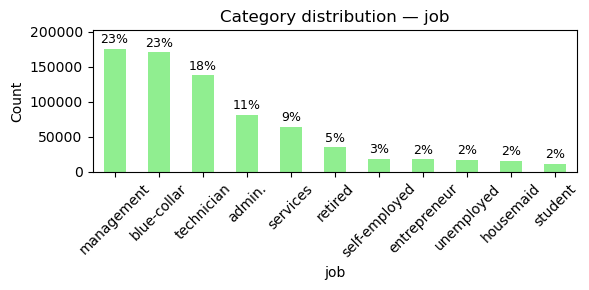

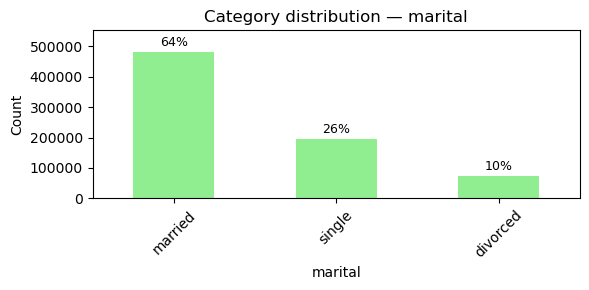

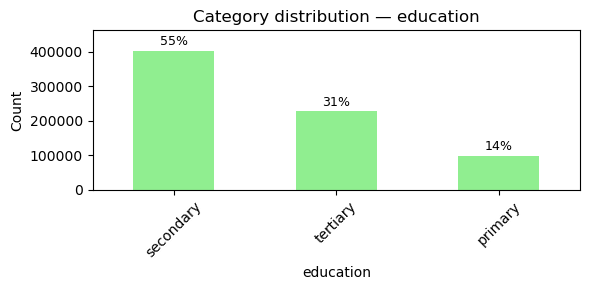

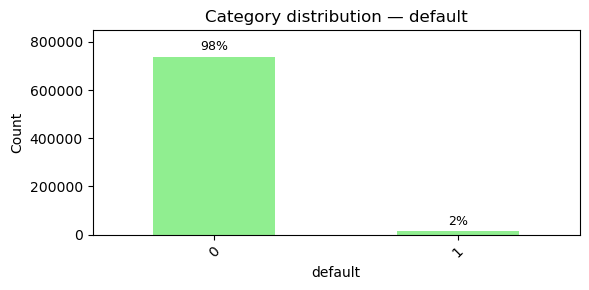

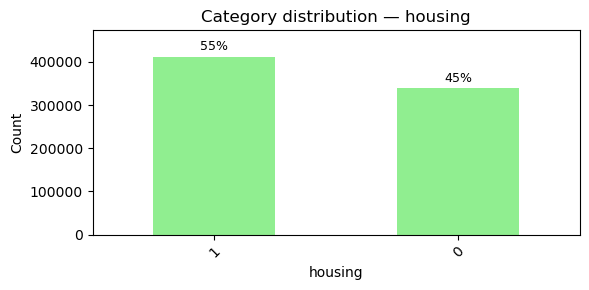

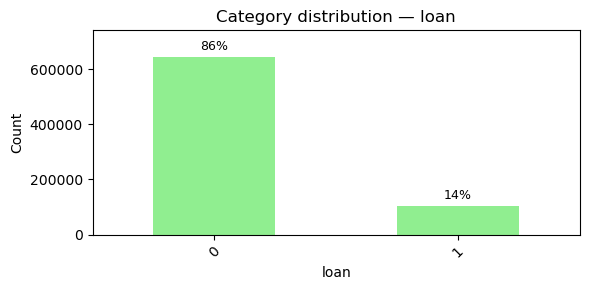

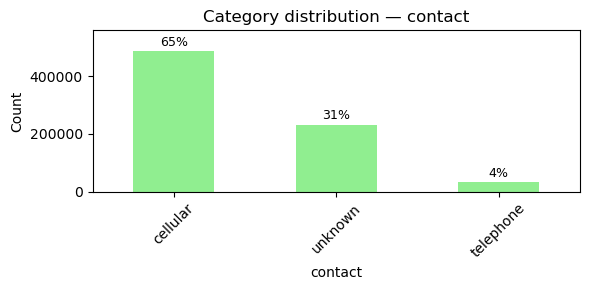

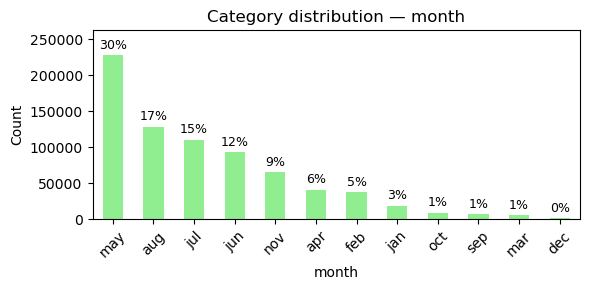

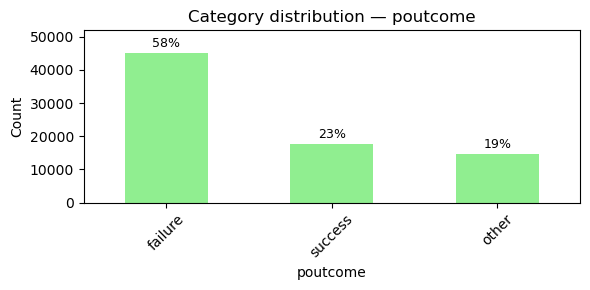

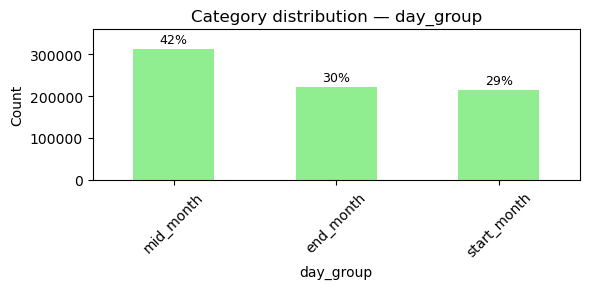

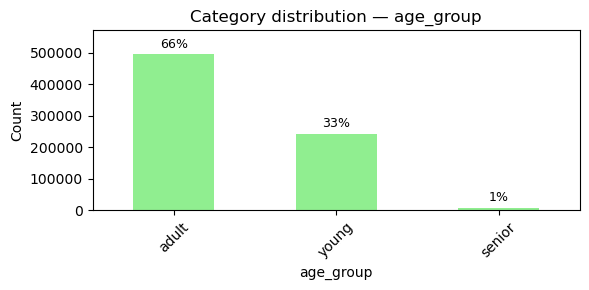

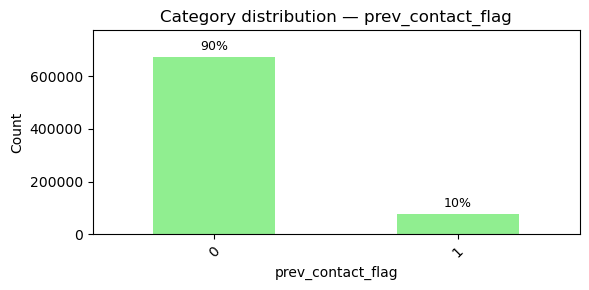

In [335]:
# -----------------------------
# Step 5: Plot frequency bars for categorical features
# - Shows distribution of categories (absolute counts + relative percentages)
# - Highlights dominant categories and rare ones
# - Useful for detecting imbalance of categories
# -----------------------------
for c in cat_cols:
    fig, ax = plt.subplots(figsize=(6, 3))

    # Count categories and sort in descending order
    counts = df_clean[c].value_counts().sort_values(ascending=False)
    total = counts.sum()

    # Bar plot
    counts.plot(kind='bar', color="lightgreen", ax=ax)
    ax.set_title(f'Category distribution — {c}')
    ax.set_xlabel(c)
    ax.set_ylabel('Count')
    ax.tick_params(axis="x", rotation=45)

    # Scale y-axis slightly higher than max to leave space for labels
    max_count = counts.max()
    ax.set_ylim(0, max_count * 1.15)

    # Add percentage labels above each bar
    for p, val in zip(ax.patches, counts):
        percent = ((val / total) * 100).round().astype(int)
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height() + max_count * 0.02,
            f"{percent}%",
            ha="center", va="bottom", fontsize=9
        )

    plt.tight_layout()
    plt.show()

### **5.4 Correlation Analysis of Numerical Features**
To explore relationships among numerical variables, we compute both **Pearson** (linear correlation) and **Spearman** (rank-based correlation) coefficients.  
Heatmaps make it easy to spot strong positive or negative associations between features.  
This step helps identify **redundant variables** (multicollinearity), potential **derived features**, and relationships that may guide business interpretation.

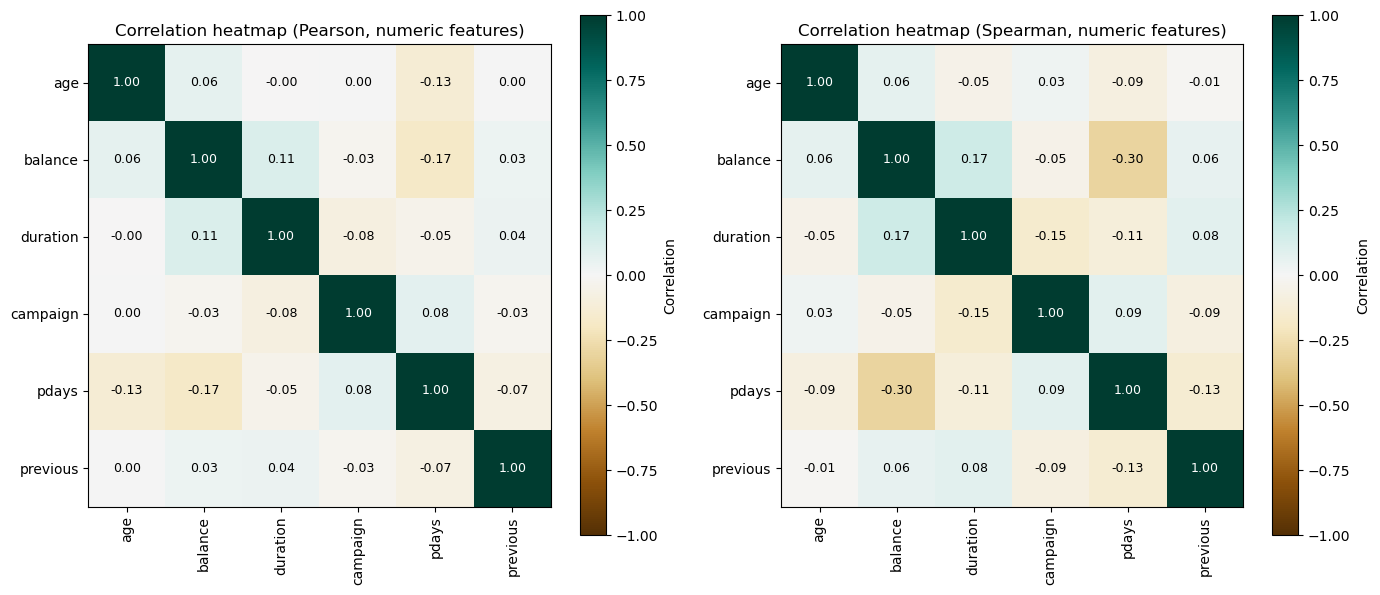

In [376]:
# -----------------------------
# Step 6: Correlation analysis
# - Pearson: measures linear correlation between numeric variables
# - Spearman: rank-based correlation, robust to non-linear monotonic relationships
# - Heatmaps: visual matrix with annotated correlation values
# -----------------------------
if len(df_clean[num_cols].columns):

    # Compute correlation matrices
    corr_p = df_clean[num_cols].corr(method='pearson')
    corr_s = df_clean[num_cols].corr(method='spearman')

    mats = [corr_p, corr_s]
    names = ['Pearson', 'Spearman']
    labels = corr_p.columns.tolist()

    # Create side-by-side heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for ax, M, name in zip(axes, mats, names):
        # Heatmap
        im = ax.imshow(M.values, vmin=-1, vmax=1, aspect='equal', cmap='BrBG')
        # Axis ticks and labels
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        ax.set_yticklabels(labels, rotation=0)

        # Annotate each cell with correlation value
        for i in range(len(labels)):
            for j in range(len(labels)):
                val = M.iat[i, j]
                txt_color = 'white' if abs(val) > 0.5 else 'black'
                ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=9, color=txt_color)

        ax.set_title(f'Correlation heatmap ({name}, numeric features)')

        # Add individual colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Correlation')

    plt.tight_layout()
    plt.show()

Overall, correlations are **weak to moderate**, meaning most variables carry relatively independent information. The most notable relationships are:  
1. **Balance vs. Duration** (wealthier clients → slightly longer conversations).  
2. **Balance vs. Pdays** (wealthier clients → contacted more recently).  
3. **Duration vs. Campaign** (longer calls → fewer attempts needed).  
These insights suggest that campaign efficiency may depend more on **call quality and timing** than on demographic characteristics like age.

## 6. **Data Visualizations to Address Business Questions**

### **6.1 Customer Profiling**
We start by examining how different **customer demographic and financial characteristics** (age, job, marital status, education, balance, loans, etc.) influence the likelihood of subscribing to a term deposit.  
For each feature, we calculate:  
- **Conversion rate** (proportion of customers who subscribed within each group).  
- **Category distribution** (share of the population in each group).  
- **Statistical significance** using a chi-square test to validate whether the differences are meaningful.  

The results are presented with a bar chart for conversion rates and another for population distribution.  
This analysis helps identify the most responsive customer segments, guiding **targeted marketing strategies**.


===== age_group ===== 
p-value: 0.00e+00 (chi-square test)


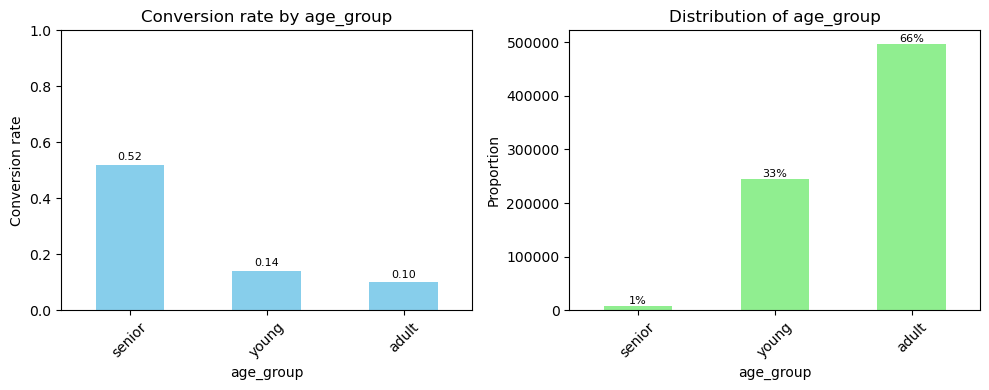

            count  count_%  conversion_rate
age_group                                  
senior       8928        1             0.52
young      243953       33             0.14
adult      497119       66             0.10

===== job ===== 
p-value: 0.00e+00 (chi-square test)


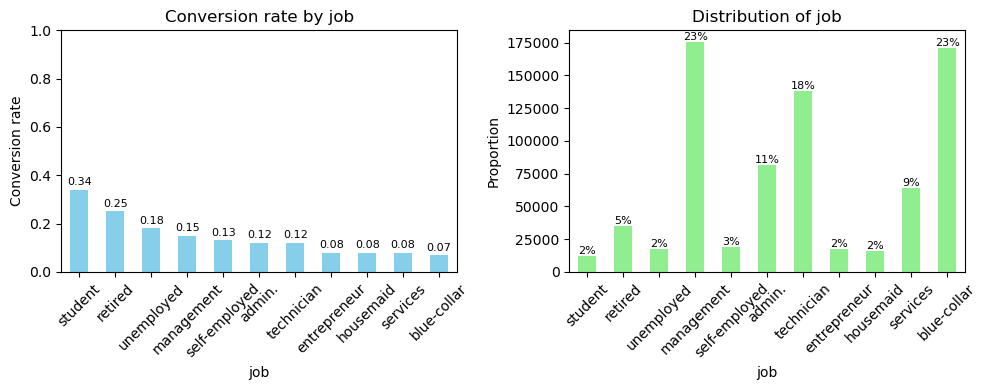

                count  count_%  conversion_rate
job                                            
student         11767        2             0.34
retired         35185        5             0.25
unemployed      17634        2             0.18
management     175541       23             0.15
self-employed   19020        3             0.13
admin.          81492       11             0.12
technician     138107       18             0.12
entrepreneur    17718        2             0.08
housemaid       15912        2             0.08
services        64209        9             0.08
blue-collar    170498       23             0.07

===== marital ===== 
p-value: 0.00e+00 (chi-square test)


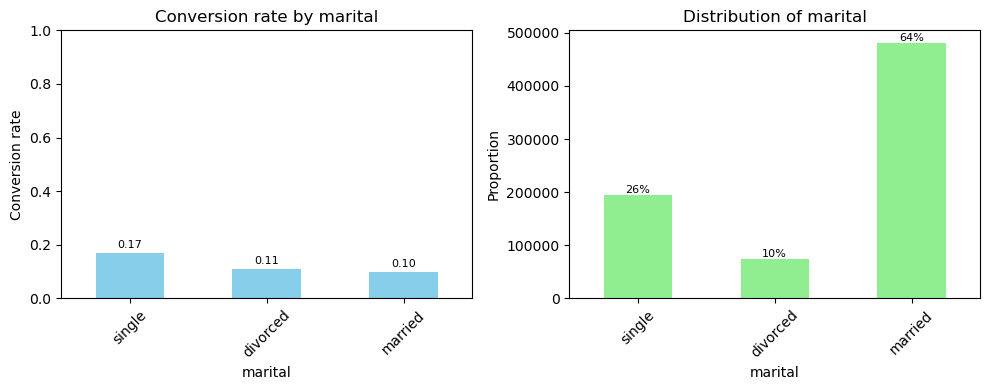

           count  count_%  conversion_rate
marital                                   
single    194834       26             0.17
divorced   74407       10             0.11
married   480759       64             0.10

===== education ===== 
p-value: 0.00e+00 (chi-square test)


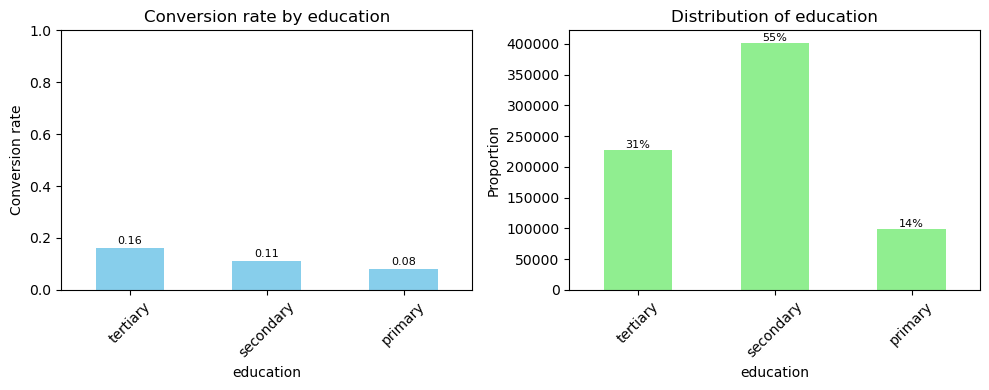

            count  count_%  conversion_rate
education                                  
tertiary   227508       31             0.16
secondary  401683       55             0.11
primary     99510       14             0.08

===== loan ===== 
p-value: 0.00e+00 (chi-square test)


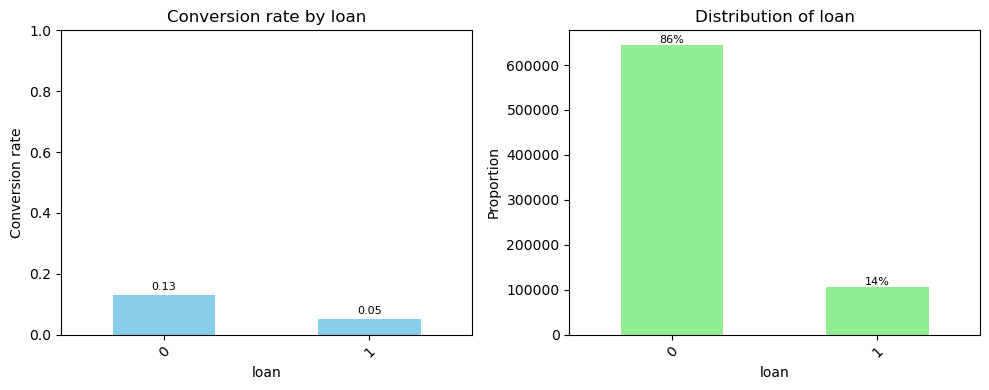

       count  count_%  conversion_rate
loan                                  
0     645023       86             0.13
1     104977       14             0.05

===== housing ===== 
p-value: 0.00e+00 (chi-square test)


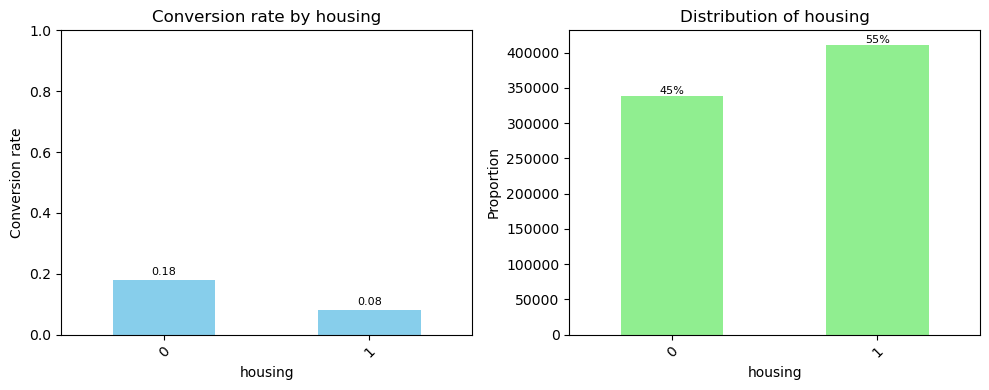

          count  count_%  conversion_rate
housing                                  
0        338712       45             0.18
1        411288       55             0.08

===== default ===== 
p-value: 5.69e-150 (chi-square test)


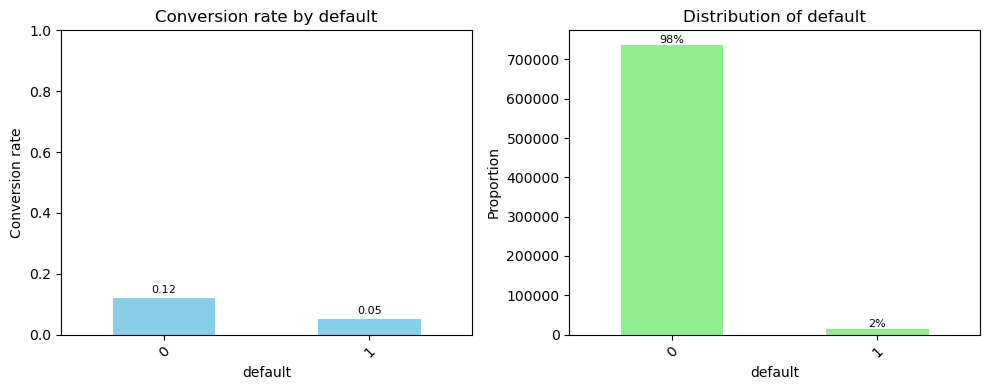

          count  count_%  conversion_rate
default                                  
0        737151       98             0.12
1         12849        2             0.05

===== balance ===== 
p-value: 0.00e+00 (chi-square test)


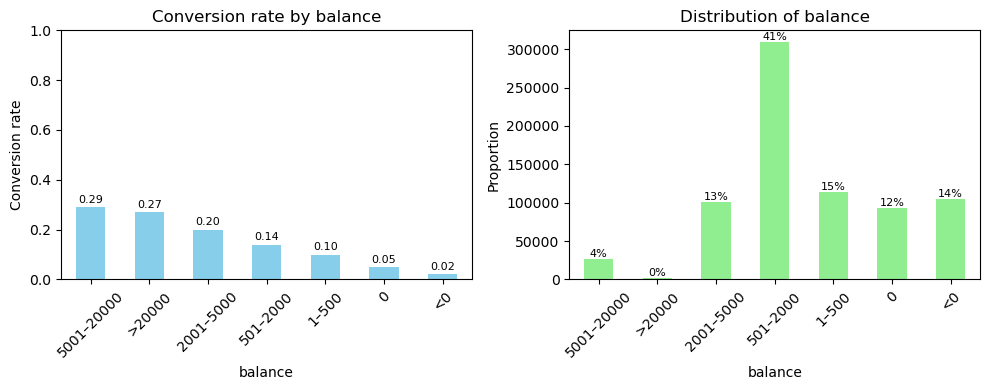

             count  count_%  conversion_rate
balance                                     
5001–20000   26935        4             0.29
>20000        2112        0             0.27
2001–5000   100289       13             0.20
501–2000    309051       41             0.14
1–500       113809       15             0.10
0            93159       12             0.05
<0          104645       14             0.02


In [331]:
# -----------------------------
# Step 1: Define helper function to analyze one feature vs target
# - Computes conversion rates, group distributions, and chi-square test
# - Plots side-by-side: conversion rate by category + population distribution
# - Returns summary table
# -----------------------------
def summarize_feature_vs_target(df, col, target_col="y", bins=None, bin_labels=None):
    """
    Analyze how a feature relates to the target variable.
    
    Parameters
    ----------
    df : DataFrame
        Input cleaned dataset.
    col : str
        Feature column to analyze.
    target_col : str, default "y"
        Target column.
    bins, bin_labels : optional
        Used to bin continuous variables (e.g., balance).
    
    Returns
    -------
    summary : DataFrame
        Table with counts, distribution rates, conversion rates, sorted by conversion.
    """

    # Drop missing values while aligning with target
    s = df[col].dropna()
    y = df.loc[s.index, target_col].astype(int)

    # Handle binning for numeric (non-binary) features
    is_numeric = pd.api.types.is_numeric_dtype(s)
    is_binary_numeric = is_numeric and set(s.unique()) <= {0, 1}
    if is_numeric and not is_binary_numeric and bins is not None:
        s = pd.cut(s, bins=bins, labels=bin_labels, include_lowest=True)

    # Category counts and proportions
    counts = s.value_counts()
    counts_rate = ((counts / counts.sum()) * 100).round().astype(int)

    # Build summary table with conversion rate
    summary = pd.DataFrame({
        "count": counts,
        "count_%": counts_rate,
        "conversion_rate": y.groupby(s, observed=True).mean().round(2)
    }).sort_values("conversion_rate", ascending=False)

    # Chi-square test for independence
    contingency = pd.crosstab(s, y)
    stat, pval, dof, expected = chi2_contingency(contingency)

    # --- Plotting ---
    print(f"\n===== {col} ===== ")
    print(f"p-value: {pval:.2e} (chi-square test)")
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left plot: conversion rate by category
    summary["conversion_rate"].plot(kind="bar", ax=axes[0], color="skyblue")
    axes[0].set_title(f"Conversion rate by {col}")
    axes[0].set_ylabel("Conversion rate")
    axes[0].set_xlabel(col)
    axes[0].set_ylim(0, 1)
    axes[0].tick_params(axis="x", rotation=45)
    for p in axes[0].patches:
        axes[0].text(p.get_x() + p.get_width()/2,
                     p.get_height() + 0.01,
                     f"{p.get_height():.2f}",
                     ha='center', va='bottom', fontsize=8)

    # Right plot: population distribution by category
    summary["count"].plot(kind="bar", ax=axes[1], color="lightgreen")
    axes[1].set_title(f"Distribution of {col}")
    axes[1].set_ylabel("Proportion")
    axes[1].set_xlabel(col)
    axes[1].tick_params(axis="x", rotation=45)
    for p, val in zip(axes[1].patches, summary["count_%"]):
        axes[1].text(p.get_x() + p.get_width()/2,
                     p.get_height() + 0.01,
                     f"{val}%",
                     ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Display summary table
    print(summary)

    return summary

# -----------------------------
# Step 2: Apply the analysis to key customer profiling features
# - Age group, job, marital, education
# - Financial: loan, housing, default, balance
# -----------------------------
customer_cols = [
    'age_group',   # grouped customer age (young, adult, senior)
    'job',         # occupation type
    'marital',     # marital status
    'education',   # highest education level
    'loan',        # personal loan (yes=1, no=0)
    'housing',     # housing loan (yes=1, no=0)
    'default',     # credit default (yes=1, no=0)
    'balance'      # account balance (can be bucketed into ranges)
]

for c in customer_cols:
    try:
        summarize_feature_vs_target(
            df_clean, c, target_col="y",
            bins=[-np.inf, -1, 0, 500, 2000, 5000, 20000, np.inf] if c == "balance" else None,
            bin_labels=["<0", "0", "1–500", "501–2000", "2001–5000", "5001–20000", ">20000"] if c == "balance" else None
        )
    except Exception as e:
        print(f"Skipping {c}: {e}")

### **6.2 Channel & Campaign Effectiveness**
We now analyze the effectiveness of different **communication channels** and **campaign strategies**.  
This includes factors such as the type of contact (cellular, telephone), whether the client had been contacted before, timing variables (month, day of month, days since last contact), call duration, number of contacts during the campaign, and outcomes of previous campaigns.  

For each feature, we bin continuous variables into meaningful groups (e.g., call duration, campaign attempts, recency of contact) and evaluate:  
- **Conversion rate**: likelihood of subscription within each group.  
- **Distribution**: proportion of customers in each group.  
- **Statistical significance** (chi-square test).  

This analysis reveals which **channels and strategies** maximize conversions and helps optimize resource allocation in future campaigns.


===== contact ===== 
p-value: 0.00e+00 (chi-square test)


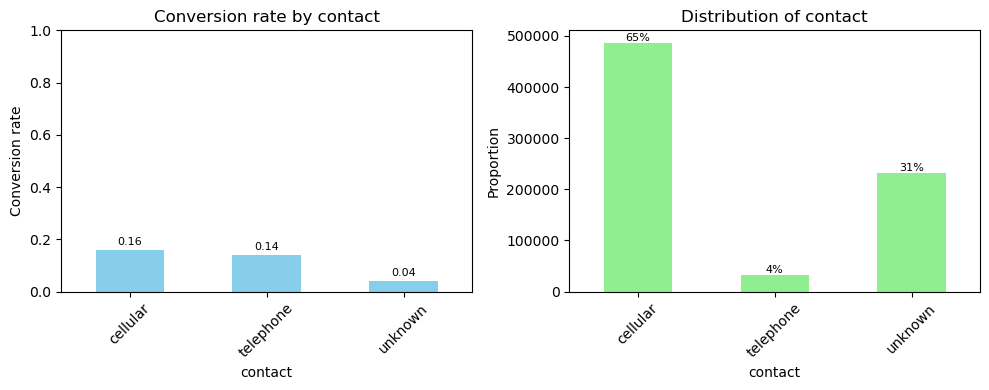

            count  count_%  conversion_rate
contact                                    
cellular   486655       65             0.16
telephone   31718        4             0.14
unknown    231627       31             0.04

===== prev_contact_flag ===== 
p-value: 0.00e+00 (chi-square test)


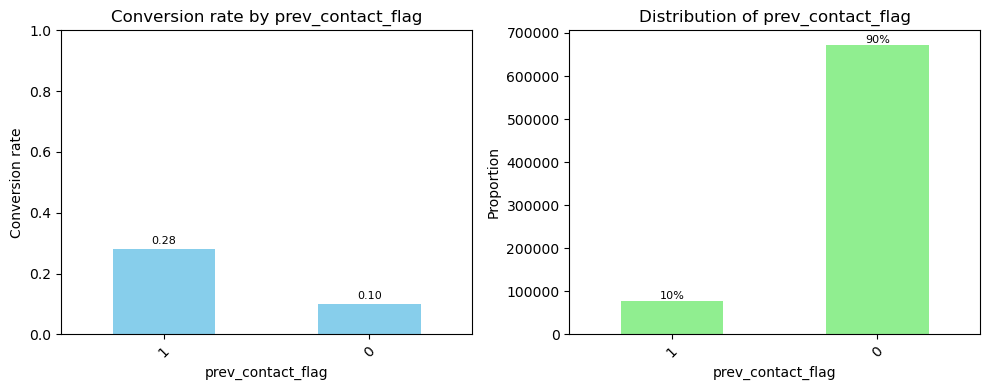

                    count  count_%  conversion_rate
prev_contact_flag                                  
1                   77566       10             0.28
0                  672434       90             0.10

===== month ===== 
p-value: 0.00e+00 (chi-square test)


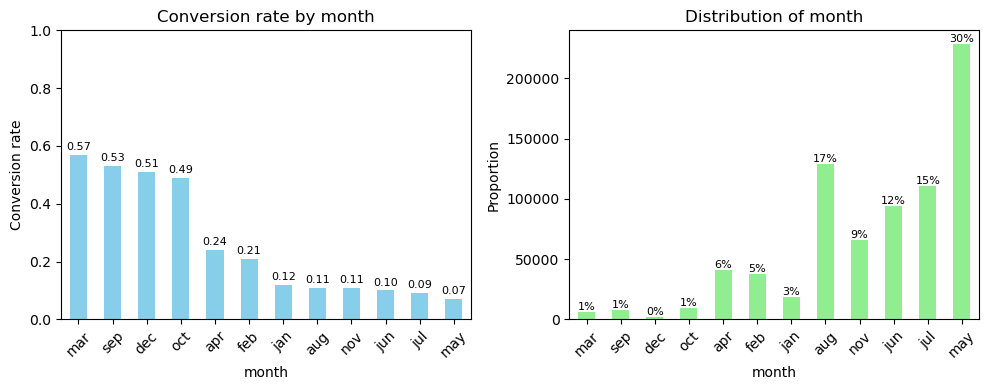

        count  count_%  conversion_rate
month                                  
mar      5802        1             0.57
sep      7409        1             0.53
dec      2069        0             0.51
oct      9204        1             0.49
apr     41319        6             0.24
feb     37611        5             0.21
jan     18937        3             0.12
aug    128859       17             0.11
nov     66062        9             0.11
jun     93670       12             0.10
jul    110647       15             0.09
may    228411       30             0.07

===== day_group ===== 
p-value: 1.05e-186 (chi-square test)


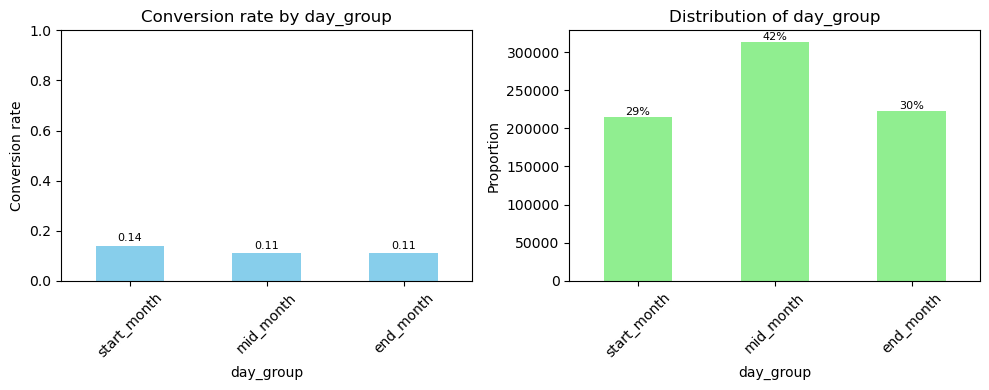

              count  count_%  conversion_rate
day_group                                    
start_month  214953       29             0.14
mid_month    312773       42             0.11
end_month    222274       30             0.11

===== pdays ===== 
p-value: 0.00e+00 (chi-square test)


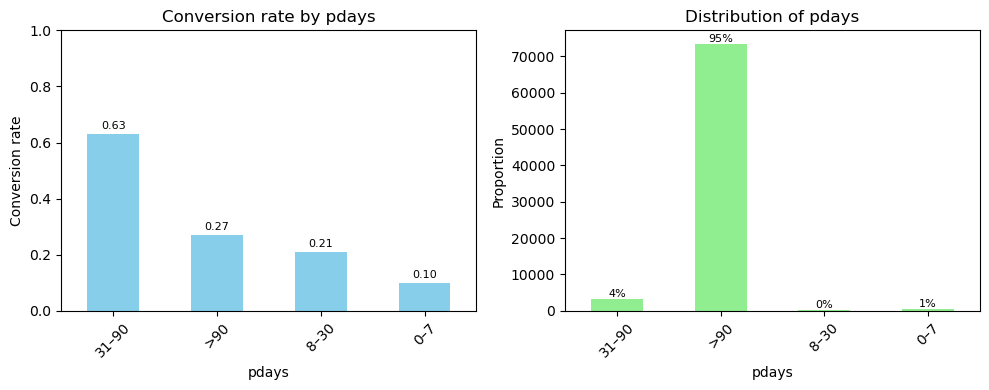

       count  count_%  conversion_rate
pdays                                 
31–90   3366        4             0.63
>90    73470       95             0.27
8–30     329        0             0.21
0–7      401        1             0.10

===== duration ===== 
p-value: 0.00e+00 (chi-square test)


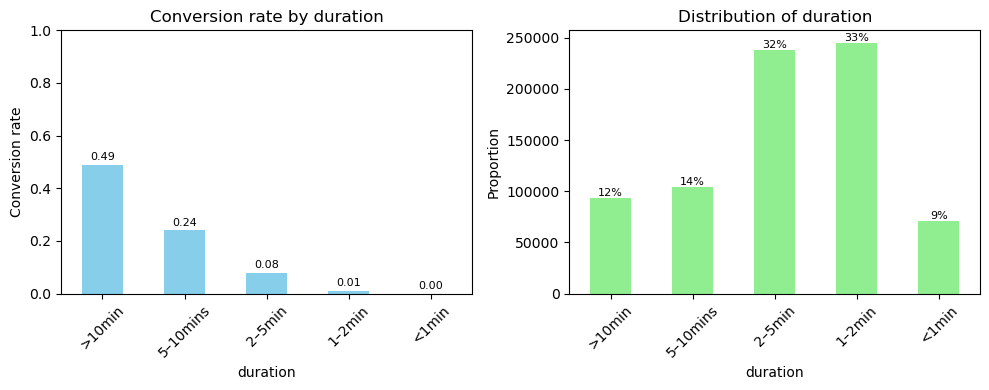

           count  count_%  conversion_rate
duration                                  
>10min     92972       12             0.49
5–10mins  103720       14             0.24
2–5min    237717       32             0.08
1–2min    245052       33             0.01
<1min      70539        9             0.00

===== campaign ===== 
p-value: 0.00e+00 (chi-square test)


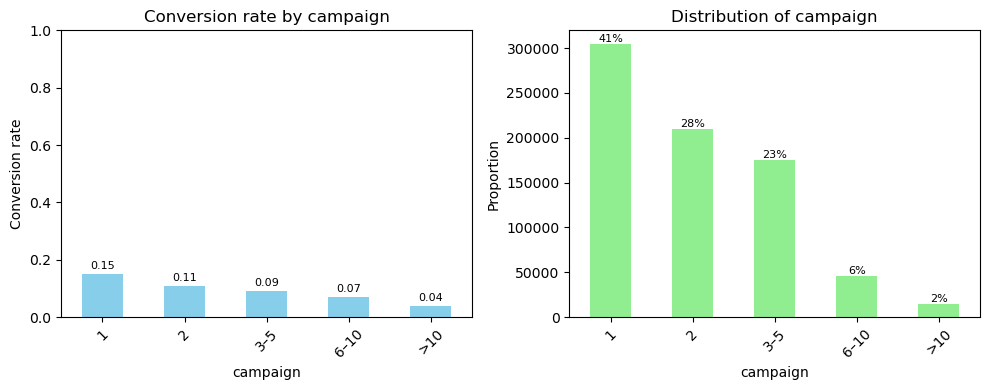

           count  count_%  conversion_rate
campaign                                  
1         304481       41             0.15
2         209834       28             0.11
3–5       175305       23             0.09
6–10       45335        6             0.07
>10        15045        2             0.04

===== previous ===== 
p-value: 0.00e+00 (chi-square test)


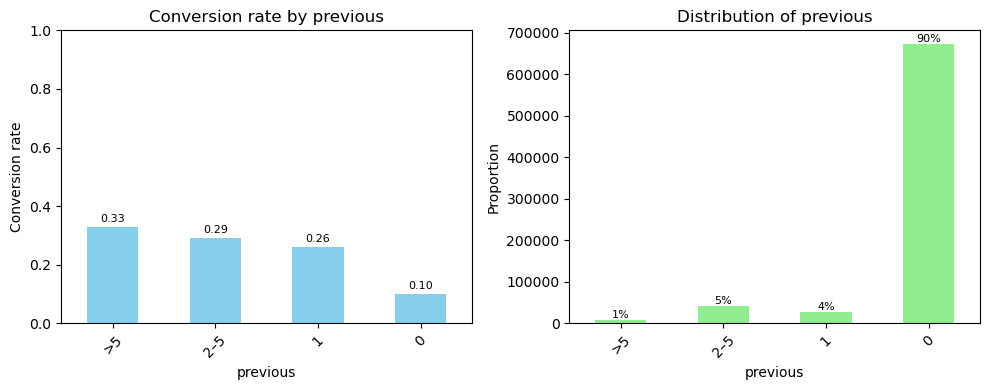

           count  count_%  conversion_rate
previous                                  
>5          8312        1             0.33
2–5        40915        5             0.29
1          28342        4             0.26
0         672431       90             0.10

===== poutcome ===== 
p-value: 0.00e+00 (chi-square test)


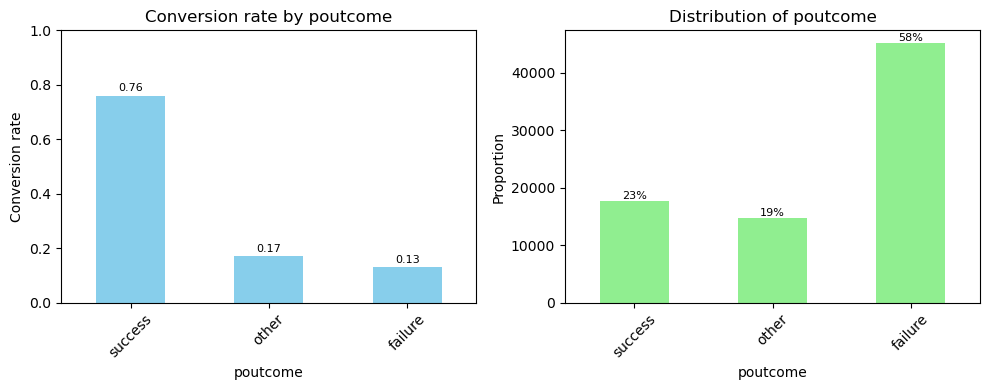

          count  count_%  conversion_rate
poutcome                                 
success   17691       23             0.76
other     14744       19             0.17
failure   45115       58             0.13


In [347]:
# -----------------------------
# Step 3: Analyze marketing campaign features vs target
# - Features include channel, contact history, timing, duration, frequency, and past outcomes
# - Uses summarize_feature_vs_target() helper defined earlier
# - For continuous campaign-related features, apply custom bins for interpretability
# -----------------------------
campaign_cols = [
    'contact',             # type of contact (cellular, telephone, unknown)
    'prev_contact_flag',   # whether customer was contacted in a previous campaign
    'month',               # month of current contact
    'day_group',           # position within month (start, mid, end)
    'pdays',               # days since last contact (recency)
    'duration',            # call duration in seconds
    'campaign',            # number of contacts in current campaign
    'previous',            # number of contacts in previous campaigns
    'poutcome'             # outcome of previous campaign
]

# Predefined binning configurations for continuous-like campaign features
BIN_CONFIGS = {
    "duration": {
        "bins": [-1, 60, 120, 300, 600, 10000],
        "labels": ["<1min", "1–2min", "2–5min", "5–10mins", ">10min"]
    },
    "campaign": {
        "bins": [0, 1, 2, 5, 10, 999],
        "labels": ["1", "2", "3–5", "6–10", ">10"]
    },
    "pdays": {
        "bins": [-0.5, 7, 30, 90, float("inf")],
        "labels": ["0–7", "8–30", "31–90", ">90"]
    },
    "previous": {
        "bins": [-1, 0, 1, 5, 999],
        "labels": ["0", "1", "2–5", ">5"]
    },
}

# Loop through each campaign-related feature and analyze
for c in campaign_cols:
    try:
        # If feature requires binning, apply predefined config
        kwargs = {}
        if c in BIN_CONFIGS:
            kwargs = {
                "bins": BIN_CONFIGS[c]["bins"],
                "bin_labels": BIN_CONFIGS[c]["labels"]
            }
        # Apply analysis with helper function
        summarize_feature_vs_target(df_clean, c, target_col="y", **kwargs)
    except Exception as e:
        print(f"Skipping {c}: {e}")

## **7. Analysis**

### **7.1 Customer Profiling**
- **Age**: Seniors show the highest conversion rate (52%), far above young (14%) and adults (10%).  
- **Job**: Groups with the highest propensity to subscribe are students (34%), retired (25%), and unemployed (18%), compared to manual jobs like blue-collar (6.7%).  
- **Marital status**: Singles (17%) convert more than married (10%) or divorced (11%).  
- **Education**: Tertiary education (16%) outperforms secondary (10%) and primary (8%).  
- **Loans**: Customers without personal or housing loans show much higher conversion. Example: no housing loan (17%) vs. with housing loan (7%).  
- **Default**: Those without default records convert more (12%) than those with defaults (4%).  
- **Balance**: Higher balances correlate with higher conversion. Example: €5,001–20,000 (28%) vs. negative balance (<0) only 2.4%.  

### **7.2 Channel & Campaign Effectiveness**
- **Contact channel**: Cellular (15.6%) outperforms telephone (13.6%) and especially "unknown" (4%).  
- **Previous contact history**: Having been contacted before increases conversion (28%) vs. never contacted (10%).  
- **Month of contact**: Strongest results in March (57%), September (53%), and December (51%); weakest in May (7%).  
- **Day of the month**: Contacts at the start of the month (13.7%) perform slightly better than mid (11.4%) or end (11.2%).  
- **Recency of contact (pdays)**: Best results when last contact was 31–90 days ago (63%) or >90 (26%); very recent (0–7 days) only 10%.  
- **Call duration**: Strong positive relationship. Calls >10 min (49%) and 5–10 min (23%) vs. <1 min (<1%).  
- **Number of contacts in current campaign**: A single call (15%) is more effective than >10 attempts (4%).  
- **Contacts in previous campaigns**: More past contacts increase success; >5 past contacts yield 32%.  
- **Outcome of previous campaigns**: If previous outcome was success, current subscription probability is extremely high (76%).  


## **8. Conclusions**

1. **Most responsive customer profile**:  
   - Seniors, students, and retirees.  
   - Singles, higher education, and higher account balances.  
   - Without active loans or defaults.  
   **Recommendation**: Prioritize campaigns targeting these segments.  

2. **Channel and timing**:  
   - Cell phone is the most effective channel.  
   - Optimal months: March, September, and December.  
   - Longer calls matter significantly.  
   **Recommendation**: Sustain longer conversations and schedule campaigns in peak months.  

3. **Campaign strategy**:  
   - Customers with previous successful contacts have much higher conversion.  
   - Fewer, well-timed contacts are more effective than excessive attempts.  
   **Recommendation**: Focus on warm leads (positive history) and avoid over-contacting low-response customers.  
---